This notebook has been made to determine a rough estimate of the receiver temperature and its error bars. This has been done by using the process described in Adam Beardsley's [memo](http://reionization.org/wp-content/uploads/2017/04/HERA19_Tsys_3April2017.pdf), which fit auto-correlation data to a simulated global sky model using the relationship.

In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
import matplotlib.pyplot as plt
import aipy
from astropy.io import fits
from scipy.stats import linregress
import os
import glob

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [2]:
def curve_to_fit(lsts, gain, offset):
    '''
    Define curve to fit data to
    offset is Tsys offset from zero = Trxr + g * <Tsky>
    '''
    global interp_values
    return (gain * interp_values + offset)

In [7]:
JD = 2458098

# Tsky_file = '/data4/tcox/HERA_IDR1_analysis/HERA_Tsky.npz'
Tsky_file = '/Users/tyler/Folders/Research/HERA/Tsys/data/HERA_tsky_fast.npz'
data = np.load(Tsky_file)
freqs = data['freqs']  # These are already made to fit the data
model_lsts = data['lsts']
model_HERA_Tsky = data['HERA_Tsky']

data = np.load('/Users/tyler/Folders/Research/HERA/Tsys/Tsys_plots/IDR2/2458098/fits.npz'.format(JD))
nrao_feeds = data['nrao_feeds']
HERA_list = data['HERA_list']
freqs = data['freqs']

# Load in data from previous script
#autos_file = '/Users/tyler/Desktop/Research/Tsys/data/IDR2_{}_autos.npz'.format(JD)
autos_file = '/Users/tyler/Folders/Research/HERA/Tsys/data/IDR2_2458098_autos.npz'
data = np.load(autos_file)
data_lsts = data['lsts']
data_ave = data['data_ave']

In [8]:
# Generate variance matrix for measurements
dB = 100.0 / data_ave.shape[3] # Bandwidth in MHz
t = 10.8 # seconds
C = data_ave / np.sqrt(1e6*dB*t)

pols = ['X', 'Y']
npol = len(pols)
nant = len(HERA_list)

new_feeds = list(set(HERA_list)-set(nrao_feeds))


# Fit auto data to model

auto_fits = np.zeros((npol, nant, len(freqs), 2))  # gain_amp, gain_slope, rxr_amp
covs = np.zeros((npol, nant, len(freqs), 2, 2))

# Create interp_func to return Tsky - <Tsky> (ie, deviation from mean)

interp_Tsky = interpolate.interp1d(model_lsts, model_HERA_Tsky, kind='cubic', axis=2, fill_value='extrapolate')
interp_Tsky_array = interp_Tsky(data_lsts[0])
Tsky_mean = np.mean(interp_Tsky_array, axis=2)
Tsky_prime = interp_Tsky_array - np.expand_dims(Tsky_mean, 2)

In [9]:
def gain_rxr_temp(auto_fits, covs, save_npz=True):
    '''
    auto_fits[:, :, :, 0] -> A_0
    auto_fits[:, :, :, 1] -> R_0
    '''
    gains = auto_fits[:, :, :, 0]
    rxr_temp = auto_fits[:, :, :, 1] / gains - Tsky_mean[:, None, :]  
    rxr_temp_err = np.sqrt(covs[:,:,:,0,0] * auto_fits[:, :, :, 1]**2 / auto_fits[:, :, :, 0]**4  + 
                           covs[:,:,:,1,1] * 1.0 / auto_fits[:, :, :, 0]**2 - 
                           2 * covs[:,:,:,0,1] * auto_fits[:, :, :, 1] / auto_fits[:, :, :, 0]**3)
    if save_npz:
        np.savez('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD), gains=gains, 
                                                                rxr_temp_err=rxr_temp_err, 
                                                                rxr_temp=rxr_temp,
                                                                auto_fits=auto_fits,
                                                                covs=covs)
    return gains, rxr_temp, rxr_temp_err

In [90]:
data_ave.shape

(2, 144, 4354, 64)

In [128]:
sim = True

if os.path.exists('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD)) and not sim:
    fits_data = np.load('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD))
    gains = fits_data['gains']
    rxr_temp_err = fits_data['rxr_temp_err']
    rxr_temp = fits_data['rxr_temp']
    covs = fits_data['covs']
    auto_fits = fits_data['auto_fits']
    
else:
    for pol in xrange(npol):
        for fi, freq in enumerate(freqs):
            interp_values = Tsky_prime[pol, fi, :]
            for anti, ant in enumerate(HERA_list):
                out = curve_fit(curve_to_fit, data_lsts[pol], data_ave[pol][ant, :, fi], 
                                bounds=(0, np.inf), absolute_sigma=True)
                auto_fits[pol, anti, fi, :] = out[0]
                covs[pol, anti, fi, :, :] = out[1]
    gains, rxr_temp, rxr_temp_err = gain_rxr_temp(auto_fits, covs, save_npz=False)

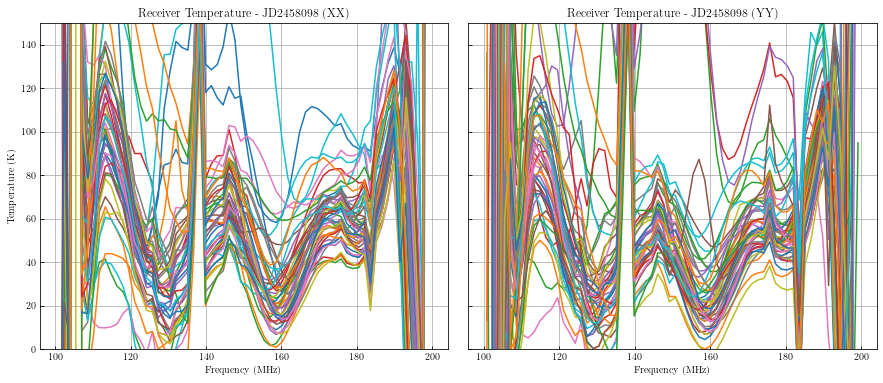

In [129]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        axarr[poli].plot(freqs, rxr_temp[poli, anti, :], label=str(ant))
    axarr[poli].set_ylim([0,150])
    axarr[0].set_ylabel('Temperature (K)')
    axarr[0].set_xlabel('Frequency (MHz)')
    axarr[1].set_xlabel('Frequency (MHz)')
    axarr[poli].set_title('Receiver Temperature - JD{JD} ({pol})'.format(JD=JD,pol=2*pol))
    axarr[poli].grid()
    
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/receiver_temp_{JD}.png'.format(JD=JD), bbox_inches='tight')



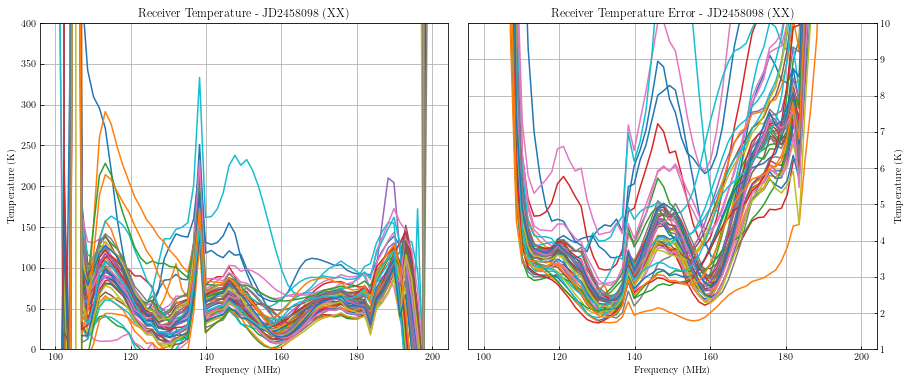

In [131]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 6))

for anti, ant in enumerate(HERA_list):
    axarr[0].plot(freqs, rxr_temp[0, anti, :], label=str(ant))
    axarr[1].plot(freqs, rxr_temp_err[0, anti, :], label=str(ant))
axarr[0].set_ylim([0,400])
axarr[1].set_ylim([1,10])
axarr[0].set_ylabel('Temperature (K)')
axarr[0].set_xlabel('Frequency (MHz)')
axarr[1].set_xlabel('Frequency (MHz)')
axarr[0].set_title('Receiver Temperature - JD{JD} (XX)'.format(JD=JD))
axarr[1].set_title('Receiver Temperature Error - JD{JD} (XX)'.format(JD=JD))
axarr[1].yaxis.tick_right()
axarr[1].yaxis.set_label_position("right")
axarr[1].set_ylabel('Temperature (K)')
axarr[0].grid()
axarr[1].grid()
plt.subplots_adjust(wspace=0.05)
plt.savefig('/Users/tyler/Downloads/rxr_temp_w_err.png', dpi=200, bbox_inches='tight')

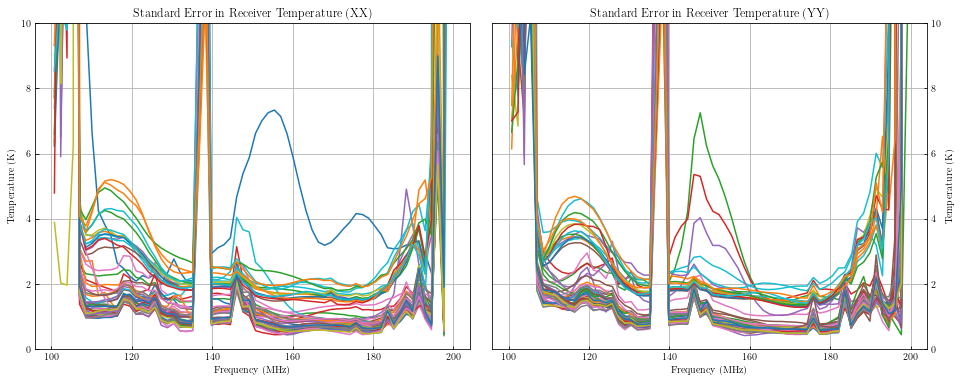

In [125]:
fig, axarr = plt.subplots(1, 2,figsize=(16, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        axarr[poli].plot(freqs, rxr_temp_err[poli, anti, :], label=str(ant))
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,10])
    axarr[poli].set_ylabel('Temperature (K)')
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[poli].set_ylabel('Temperature (K)')
    axarr[poli].set_title('Standard Error in Receiver Temperature ({})'.format(2*pol))
axarr[0].grid()
axarr[1].grid()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/rxr_standard_err_{pol}_{JD}.png'.format(pol=2*pol, JD=JD), bbox_inches='tight')


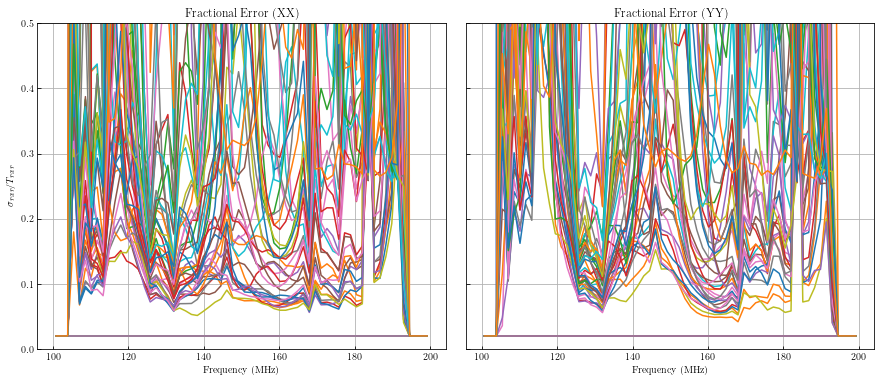

In [29]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        axarr[poli].plot(freqs, rxr_temp_err[poli, anti, :] / np.abs(rxr_temp[poli, anti, :]), label=str(ant))
    axarr[poli].set_title('Fractional Error ({})'.format(2*pol))
    axarr[0].set_ylabel(r'$\sigma_{rxr} / T_{rxr}$')
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,0.5])
    #axarr[poli].legend()
    axarr[poli].grid()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/rxr_fraction_err_{JD}.png'.format(JD=JD), bbox_inches='tight')


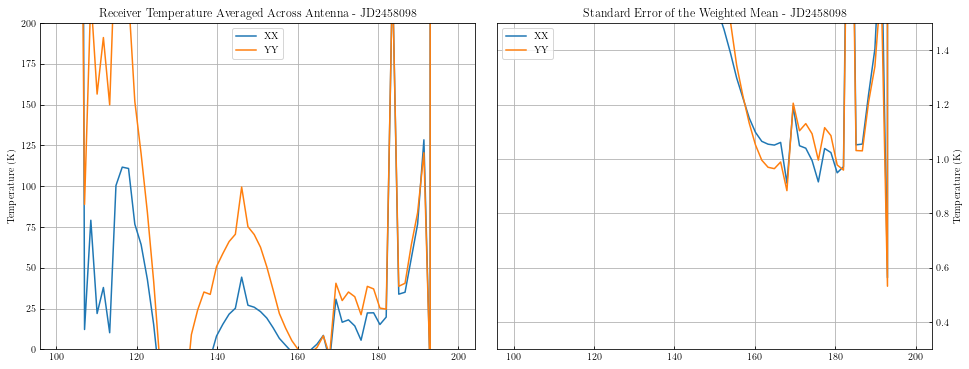

In [30]:
avg_temps = np.zeros((2, rxr_temp.shape[2]))
avg_err = np.zeros((2, rxr_temp.shape[2]))

fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

for poli, pol in enumerate(pols):
    for i in np.arange(rxr_temp.shape[2]):
        avg_temps[poli,i] = np.average(rxr_temp[poli,:,i], weights=1.0/rxr_temp_err[poli,:,i])
        avg_err[poli,i] = np.sqrt(1.0 / np.sum(rxr_temp_err[poli,:,i]**(-2)) )
        
    axarr[0].plot(freqs, avg_temps[poli,:], label=str(2*pol))      
    axarr[0].set_title('Receiver Temperature Averaged Across Antenna - JD{}'.format(JD))
    axarr[0].set_ylim([0,200])
    axarr[0].set_ylabel('Temperature (K)')
    axarr[1].set_ylabel('Temperature (K)')
    axarr[1].plot(freqs, avg_err[poli,:], label=str(2*pol)) 
    axarr[1].set_title('Standard Error of the Weighted Mean - JD{}'.format(JD))
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[1].set_ylim([0.3,1.5])
    axarr[0].legend()
    axarr[1].legend()
    axarr[poli].grid()

plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/avg_temp_w_err_{JD}.png'.format(JD=JD), bbox_inches='tight')


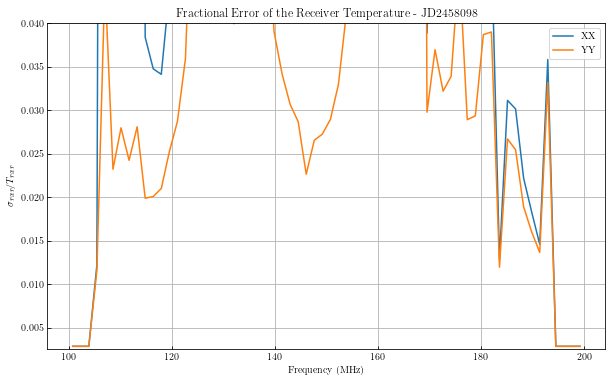

In [18]:
plt.figure(figsize=(10,6))
plt.plot(freqs, avg_err[0,:] / np.abs(avg_temps[0,:]), label='XX')
plt.plot(freqs, avg_err[1,:] / np.abs(avg_temps[1,:]), label='YY')
plt.ylim([0.0025,0.04])
plt.title('Fractional Error of the Receiver Temperature - JD{}'.format(JD))
plt.xlabel('Frequency (MHz)')
plt.ylabel(r'$\sigma_{rxr} / T_{rxr}$')
plt.legend()
plt.grid()
#plt.show()
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/avg_fractional_err_{JD}.png'.format(JD=JD), bbox_inches='tight')



# Data Fraction Dependence on the Error Bars

## Random LST values

In [27]:
JD = 2458098

data = np.load('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/2458098/fits.npz'.format(JD))
nrao_feeds = data['nrao_feeds']
HERA_list = data['HERA_list']
freqs = data['freqs']

# Load in data from previous script
autos_file = '/Users/tyler/Desktop/Research/Tsys/data/IDR2_{}_autos.npz'.format(JD)
data = np.load(autos_file)
data_lsts = data['lsts']
data_ave = data['data_ave']


In [28]:
data_frac = [0.1, 0.25, 0.5, 0.75, 0.9, 1.0]

selected_ant = 53
ant_idx = np.where(HERA_list == selected_ant)[0]

rxr_temp_var_frac = []
rxr_temp_err_frac = []

auto_fits = np.zeros((npol,len(freqs), 2))
covs = np.zeros((npol, len(freqs), 2, 2))

np.random.seed(0)

for di, frac in enumerate(data_frac):
    idx = np.random.choice(np.arange(data['data_ave'].shape[2]), size=int(data['data_ave'].shape[2]*frac), replace=False)
    data_ave = data['data_ave'][:,:,idx,:]
    data_lsts = data['lsts'][:,idx]
    interp_Tsky = interpolate.interp1d(model_lsts, model_HERA_Tsky, kind='cubic', axis=2, fill_value='extrapolate')
    interp_Tsky_array = interp_Tsky(data_lsts[0])
    Tsky_mean = np.mean(interp_Tsky_array, axis=2)
    Tsky_prime = interp_Tsky_array - np.expand_dims(Tsky_mean, 2)
    for pol in xrange(npol):
        for fi, freq in enumerate(freqs):
            interp_values = Tsky_prime[pol, fi, :]
            out = curve_fit(curve_to_fit, data_lsts[pol], data_ave[pol][selected_ant, :, fi],
                            bounds=(0, np.inf), absolute_sigma=True)
            auto_fits[pol, fi, :] = out[0]
            covs[pol, fi, :, :] = out[1]
    rxr_temp = auto_fits[:,:,1] / auto_fits[:,:, 0] - Tsky_mean[:, :]
    rxr_temp_err = np.sqrt(covs[:,:,0,0] * auto_fits[:, :, 1]**2 / auto_fits[:, :, 0]**4  + 
                           covs[:,:,1,1] * 1.0 / auto_fits[:, :, 0]**2 - 
                           2 * covs[:,:,0,1] * auto_fits[:, :, 1] / auto_fits[:, :, 0]**3)
    rxr_temp_var_frac.append(rxr_temp)
    rxr_temp_err_frac.append(rxr_temp_err)

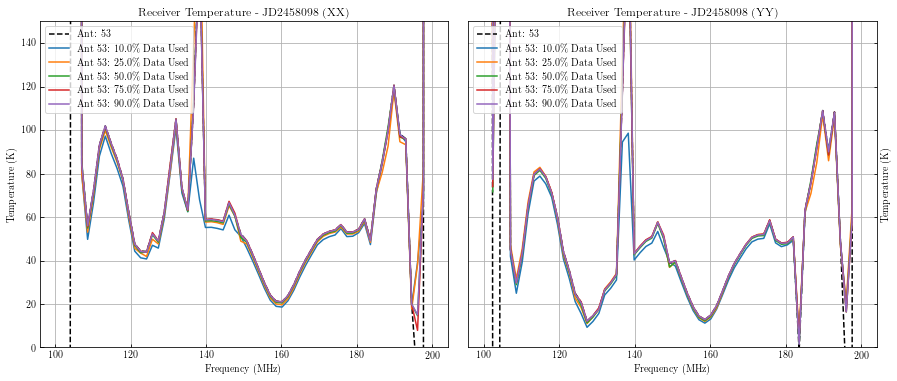

In [29]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    axarr[poli].plot(freqs, rxr_temp_var_frac[-1][poli], 'k--',label='Ant: {ant}'.format(ant=selected_ant))
    for i in np.arange(len(rxr_temp_var_frac)-1):
        axarr[poli].plot(freqs, np.abs(rxr_temp_var_frac[i][poli]),
                         label='Ant {ant}: {frac}\% Data Used'.format(ant=selected_ant,frac=data_frac[i]*100))
    axarr[poli].set_ylim([0,150])
    axarr[poli].set_ylabel('Temperature (K)')
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_title('Receiver Temperature - JD{JD} ({pol})'.format(JD=JD,pol=2*pol))
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[poli].grid()
    axarr[poli].legend()
plt.subplots_adjust(wspace=0.05)
plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/frac_data_rxr_temp_ant_{ant}_{JD}.png'.format(JD=JD, ant=selected_ant), bbox_inches='tight')



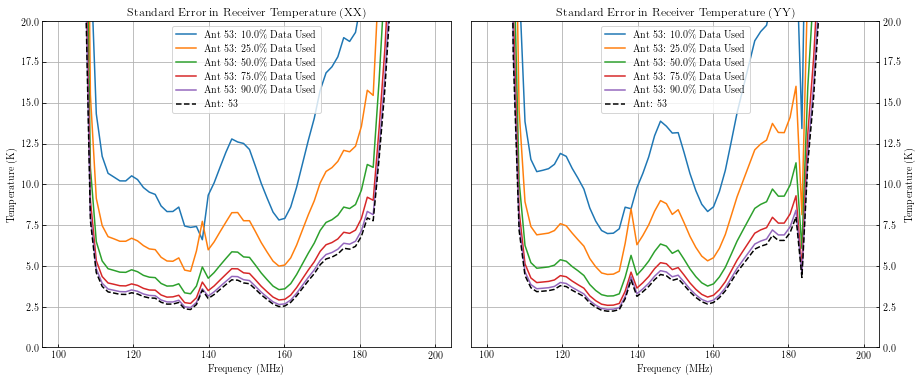

In [30]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for i in np.arange(len(rxr_temp_var_frac)-1):
        axarr[poli].plot(freqs, rxr_temp_err_frac[i][poli],
                      label='Ant {ant}: {frac}\% Data Used'.format(ant=selected_ant,frac=data_frac[i]*100))
    axarr[poli].plot(freqs, rxr_temp_err_frac[-1][poli], 'k--', label='Ant: {ant}'.format(ant=selected_ant))
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,20])
    axarr[poli].set_ylabel('Temperature (K)')
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[0].set_ylabel('Temperature (K)')
    axarr[poli].set_title('Standard Error in Receiver Temperature ({})'.format(2*pol))
    axarr[poli].grid()
    axarr[poli].legend()
plt.subplots_adjust(wspace=0.05)
plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/frac_data_rxr_standard_err_ant_{ant}_{JD}.png'.format(ant=selected_ant, JD=JD), bbox_inches='tight')



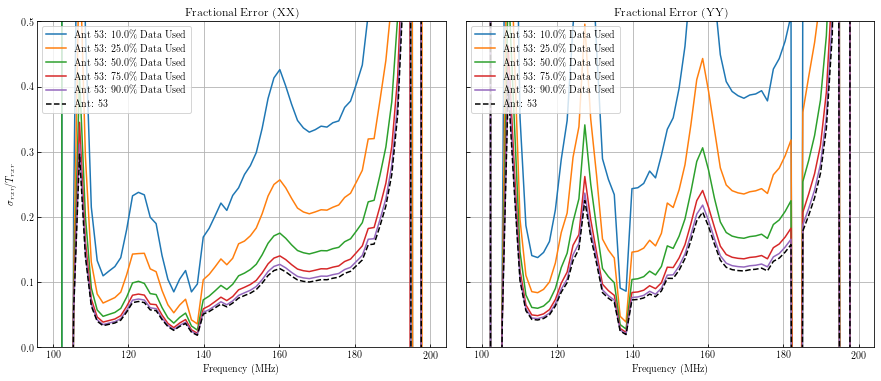

In [31]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for i in np.arange(len(rxr_temp_var_frac)-1):
        axarr[poli].plot(freqs, rxr_temp_err_frac[i][poli] / rxr_temp_var_frac[i][poli],
                         label='Ant {ant}: {frac}\% Data Used'.format(ant=selected_ant,frac=data_frac[i]*100))
    axarr[poli].plot(freqs, rxr_temp_err_frac[-1][poli] / rxr_temp_var_frac[-1][poli], 
                     'k--', label='Ant: {ant}'.format(ant=selected_ant))
    axarr[poli].set_title('Fractional Error ({})'.format(2*pol))
    axarr[0].set_ylabel(r'$\sigma_{rxr} / T_{rxr}$')
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,0.5])
    axarr[poli].grid()
    axarr[poli].legend()
plt.subplots_adjust(wspace=0.05)
plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/frac_data_rxr_fraction_err_ant_{ant}_{JD}.png'.format(JD=JD, ant=selected_ant), bbox_inches='tight')



## Chunked LST

In [244]:
JD = 2458098

# Load in data from previous script
autos_file = '/Users/tyler/Desktop/Research/Tsys/data/IDR2_{}_autos.npz'.format(JD)
data = np.load(autos_file)
data_lsts = data['lsts']
data_ave = data['data_ave']


interp_Tsky = interpolate.interp1d(model_lsts, model_HERA_Tsky, kind='cubic', axis=2, fill_value='extrapolate')
interp_Tsky_array = interp_Tsky(data_lsts[0])
Tsky_mean = np.mean(interp_Tsky_array, axis=2)
Tsky_prime = interp_Tsky_array - np.expand_dims(Tsky_mean, 2)

In [249]:
idx = np.where(np.diff(data_lsts[0]) > 1)[0][0]
new_lsts = np.append(data_lsts[:,idx+1:],data_lsts[:,:idx+1], axis=1)
new_data = np.append(data_ave[:,:,idx+1:,:],data_ave[:,:,:idx+1,:], axis=2)
new_Tsky_prime = np.append(Tsky_prime[:,:,idx+1:], Tsky_prime[:,:,:idx+1], axis=2)

In [252]:
pf = [ d for d in xrange(2,int(np.sqrt(new_data.shape[2]-2))) if (new_data.shape[2]-2) % d == 0 ]

In [253]:
pf

[2, 4, 8, 16, 17, 32, 34, 64]

In [254]:
data_chunks = np.split(new_data[:,:,2:], pf[1], axis = 2)
lst_chunks = np.split(new_lsts[:,2:], pf[1], axis = 1)
Tsky_prime_chucks = np.split(new_Tsky_prime[:,:,2:], pf[1], axis = 2)

In [255]:
selected_ant = 53
ant_idx = np.where(HERA_list == selected_ant)[0]

rxr_temp_chunks = []
rxr_temp_err_chunks = []

lst_size = new_lsts.shape[1]

for di in xrange(len(data_chunks)):
    
    auto_fits = np.zeros((npol,len(freqs), 2))
    covs = np.zeros((npol, len(freqs), 2, 2))
    
    data_ave = data_chunks[di]
    data_lsts = lst_chunks[di]
    Tsky_prime = Tsky_prime_chucks[di]
    
    for pol in xrange(npol):
        for fi, freq in enumerate(freqs):
            interp_values = Tsky_prime[pol, fi, :]
            out = curve_fit(curve_to_fit, data_lsts[pol], data_ave[pol][selected_ant, :, fi],
                            bounds=(0, np.inf), absolute_sigma=True)
            auto_fits[pol, fi, :] = out[0]
            covs[pol, fi, :, :] = out[1]
            
    rxr_temp = auto_fits[:,:,1] / auto_fits[:,:, 0] - Tsky_mean[:, :]
    rxr_temp_err = np.sqrt(covs[:,:,0,0] * auto_fits[:, :, 1]**2 / auto_fits[:, :, 0]**4  + 
                           covs[:,:,1,1] * 1.0 / auto_fits[:, :, 0]**2 - 
                           2 * covs[:,:,0,1] * auto_fits[:, :, 1] / auto_fits[:, :, 0]**3)
    rxr_temp_chunks.append(rxr_temp)
    rxr_temp_err_chunks.append(rxr_temp_err)

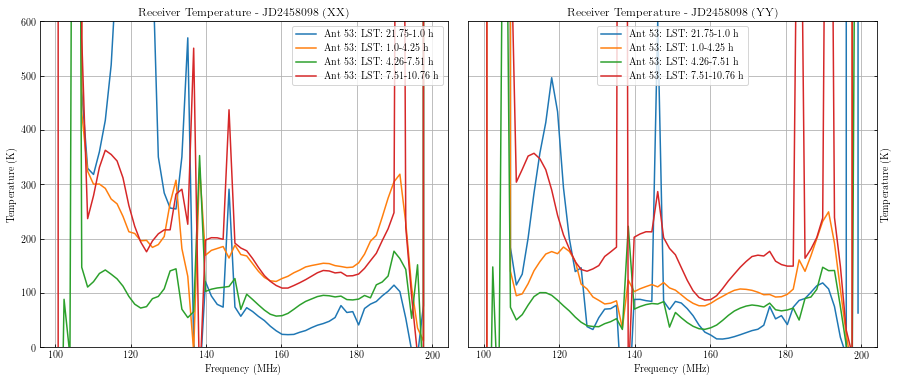

In [256]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for di in xrange(len(data_chunks)):
        axarr[poli].plot(freqs, rxr_temp_chunks[di][poli],
                         label='Ant {ant}: LST: {lst1}-{lst2} h'.format(ant=selected_ant,lst1=round(lst_chunks[di][0,0],2), 
                                                                      lst2=round(lst_chunks[di][0,-1],2)))
    axarr[poli].set_ylim([0,600])
    axarr[poli].set_ylabel('Temperature (K)')
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_title('Receiver Temperature - JD{JD} ({pol})'.format(JD=JD,pol=2*pol))
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[poli].grid()
    axarr[poli].legend()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/frac_data_rxr_temp_ant_{ant}_{JD}.png'.format(JD=JD, ant=selected_ant), bbox_inches='tight')


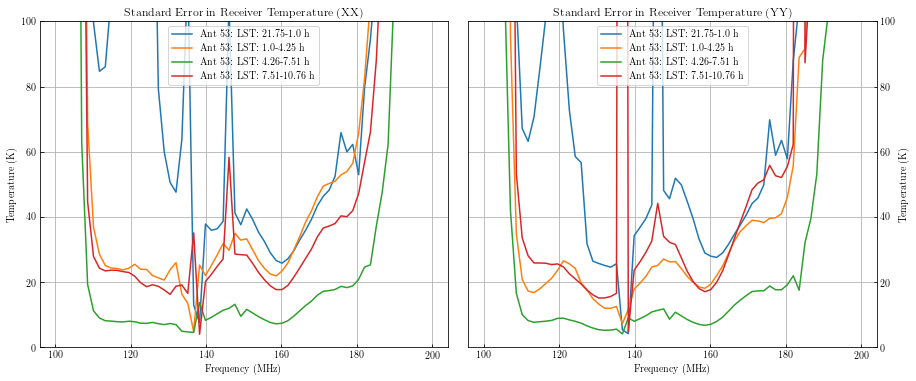

In [257]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for di in xrange(len(data_chunks)):
        axarr[poli].plot(freqs, rxr_temp_err_chunks[di][poli],
                         label='Ant {ant}: LST: {lst1}-{lst2} h'.format(ant=selected_ant,lst1=round(lst_chunks[di][0,0],2), 
                                                                      lst2=round(lst_chunks[di][0,-1],2)))
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,100])
    axarr[poli].set_ylabel('Temperature (K)')
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[0].set_ylabel('Temperature (K)')
    axarr[poli].set_title('Standard Error in Receiver Temperature ({})'.format(2*pol))
    axarr[poli].grid()
    axarr[poli].legend()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/frac_data_rxr_standard_err_ant_{ant}_{JD}.png'.format(ant=selected_ant, JD=JD), bbox_inches='tight')


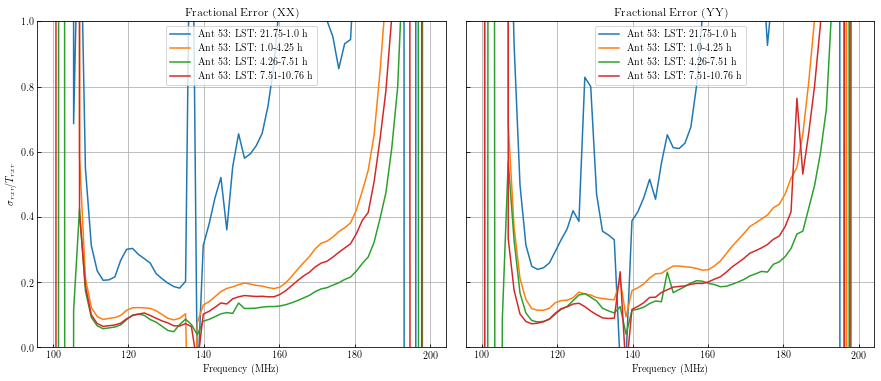

In [258]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for di in xrange(len(data_chunks)):
        axarr[poli].plot(freqs, rxr_temp_err_chunks[di][poli] / rxr_temp_chunks[di][poli],
                         label='Ant {ant}: LST: {lst1}-{lst2} h'.format(ant=selected_ant,lst1=round(lst_chunks[di][0,0],2), 
                                                                      lst2=round(lst_chunks[di][0,-1],2)))
    axarr[poli].set_title('Fractional Error ({})'.format(2*pol))
    axarr[0].set_ylabel(r'$\sigma_{rxr} / T_{rxr}$')
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,1])
    axarr[poli].grid()
    axarr[poli].legend()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/frac_data_rxr_fraction_err_ant_{ant}_{JD}.png'.format(JD=JD, ant=selected_ant), bbox_inches='tight')


63.02440147964676
80.20072220896185
187.98983571059716
127.86376215263228


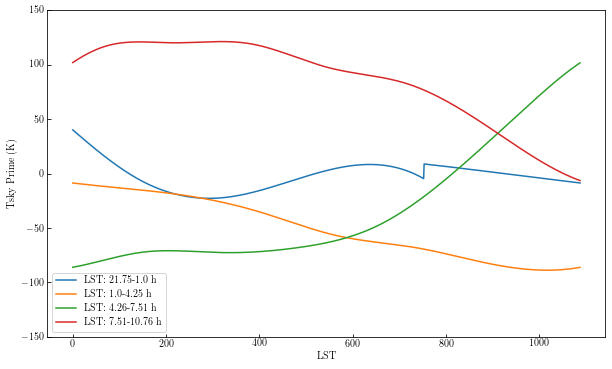

In [261]:
plt.figure(figsize=(10,6))

avd = []

for di in xrange(len(data_chunks)):
    data_ave = data_chunks[di]
    data_lsts = lst_chunks[di]
    Tsky_prime = Tsky_prime_chucks[di]
    avd.append(np.mean(Tsky_prime[1,:,:], axis=0))
    plt.plot(np.mean(Tsky_prime[1,:,:], axis=0), label='LST: {lst1}-{lst2} h'.format(lst1=round(lst_chunks[di][0,0],2), 
                                                                      lst2=round(lst_chunks[di][0,-1],2)))
    print np.mean(Tsky_prime[1,:,:], axis=0).max()-np.mean(Tsky_prime[1,:,:], axis=0).min()

plt.ylim([-150,150])
plt.xlabel('LST')
plt.ylabel('Tsky Prime (K)')
plt.legend()
plt.show()